# Import libraries

In [1]:
from utils.coords.transforms import *
from utils.coords.metrics import *
from utils.load_config import load_config

In [2]:
from utils.telescope.bandpass.bandpass_gains import *

In [3]:
from utils.helper.write_to_zarr import *

In [4]:
from utils.rime.rime_comps import *

In [5]:
from utils.rime.rime_comps_dask import RIME

In [6]:
from utils.rfi.rfi_spectra.sim_rfi_spectra import get_rfi_spectra

In [7]:
from utils.rfi.sat_sim.satellite_simulations import get_dist_and_seps, get_archival_tles

In [8]:
from utils.telescope.beams import auto_beam, cross_beam

In [9]:
from skyfield.api import load as sf_load

In [10]:
import matplotlib.pyplot as plt

In [11]:
import dask.array as da

In [12]:
import datetime

In [13]:
%matplotlib inline

In [14]:
s0 = datetime.datetime.now()

# Load Config

In [15]:
config = load_config('config.yml')


No frequency ranges set for satellites.

No frequency ranges set for cell_towers.

No frequency ranges set for planes.

No GPS coordinates set for cell towers.

No flight paths set for planes.


# Calculate obs times

In [16]:
all_times = [config['observation']['start_datetime'] + i*config['observation']['int_time'] 
             for i in range(config['observation']['time_steps'])]

# Choose target and astro sources

In [17]:
astro = config['astronomical']['sky_model']

In [18]:
sep = angular_separation(astro[:,0], astro[:,1], config['observation']['target'])

In [19]:
np.argmin(sep), np.min(sep)

(272634, 0.15009923799627237)

In [20]:
astro[np.argmin(sep), :2], config['observation']['target']

(array([ 20.827, -29.991]), array([ 21., -30.]))

In [21]:
config['observation']['target'] = astro[np.argmin(sep), :2]

In [22]:
sep = angular_separation(astro[:,0], astro[:,1], config['observation']['target'])

In [23]:
chosen = np.where(sep<config['astronomical']['radius'])[0]

In [24]:
chosen.shape

(1,)

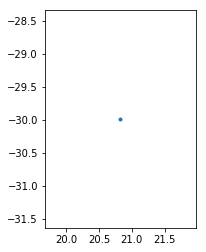

In [25]:
plt.plot(astro[chosen,0], astro[chosen,1], '.')
plt.gca().set_aspect('equal', adjustable='box')

In [26]:
config['astronomical']['inview'] = astro[chosen]

# Problem size

In [27]:
n_time = config['observation']['time_steps']

In [28]:
n_freq = len(config['telescope']['frequencies'])

In [29]:
n_ant = len(config['telescope']['ENU_coords'])

# Calculate UVW coords

In [30]:
ra, dec = config['observation']['target']

In [31]:
enu = config['telescope']['ENU_coords']

In [32]:
lat, lon, el = config['telescope']['GPS_coords']

In [33]:
uvw = ENU_to_UVW(enu, lat, lon, ra, dec, all_times)

# Get frequencies

In [34]:
freqs = config['telescope']['frequencies']

# Calculate brightness matrices - astro

In [35]:
freq0 = 863e6
I, SI = config['astronomical']['inview'][:,2:].T
I_astro = I[None,None,:]*(freqs[None,:,None]/freq0)**SI[None,None,:]
Q = np.zeros_like(I_astro)
U = np.zeros_like(I_astro)
V = np.zeros_like(I_astro)
B_astro = brightness_matrix(I_astro, Q, U, V)

In [36]:
B_astro = write_to_zarr(B_astro, 'B_astro', config, time_axis=2, freq_axis=3) * \
          da.ones((2,2,n_time,n_freq,len(config['astronomical']['inview'])))

In [37]:
B_astro

dask.array<mul, shape=(2, 2, 100, 4096, 1), dtype=complex128, chunksize=(2, 2, 100, 1, 1)>

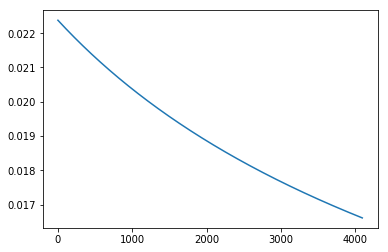

In [38]:
plt.plot(B_astro[1,1,0,:,:3].real)

# Calculate phase delays - astro

In [39]:
lmn = np.array(radec_to_lmn(config['astronomical']['inview'][:,0], 
                   config['astronomical']['inview'][:,1],
                   config['observation']['target'])).T

In [40]:
distances = np.dot(uvw, lmn.T)

In [41]:
distances.shape

(100, 64, 1)

In [42]:
K_astro = phase_delays(distances, freqs)

In [43]:
K_astro = write_to_zarr(K_astro, 'K_astro', config, time_axis=0, freq_axis=1)

In [44]:
K_astro

dask.array<from-zarr, shape=(100, 4096, 64, 1), dtype=complex128, chunksize=(100, 1, 64, 1)>

# Calculate DDE - astro

In [45]:
config['astronomical']['inview'][:,0].shape

(1,)

In [46]:
config['observation']['target']

array([ 20.827, -29.991])

In [47]:
E_astro = pol_beam(config['astronomical']['inview'][None,None,:,0], 
                   config['astronomical']['inview'][None,None,:,1],
                   freqs, config['observation']['target'],
                   auto_beam, cross_beam)

In [48]:
E_astro.shape

(2, 2, 1, 4096, 1, 1)

In [49]:
E_astro = write_to_zarr(E_astro, 'E_astro', config, time_axis=2, freq_axis=3) * \
          da.ones((2,2,n_time,n_freq,len(config['telescope']['ENU_coords']),
                   len(config['astronomical']['inview'])))

In [50]:
E_astro

dask.array<mul, shape=(2, 2, 100, 4096, 64, 1), dtype=complex128, chunksize=(2, 2, 100, 1, 64, 1)>

# Choose satellites

In [51]:
config['observation']['duration']

datetime.timedelta(0, 100)

In [52]:
start_obs = config['observation']['start_datetime']
obs_time = config['observation']['duration']
gps_ants = ENU_to_GPS_el(config['telescope']['GPS_coords'], config['telescope']['ENU_coords'])
one_day = datetime.timedelta(days=1)
start_obs_ntz = start_obs.replace(tzinfo=None)
tles = sf_load.tle(get_archival_tles(start_obs_ntz-one_day, start_obs_ntz+one_day))

File 2019-02-20.tle exists and is readable.


In [53]:
obs_times = [start_obs+i*0.5*obs_time for i in range(3)]
el_dist_ra_dec_sep = get_dist_and_seps(list(tles.values()), gps_ants, obs_times, [ra, dec])
means = np.mean(el_dist_ra_dec_sep, axis=(0,1), keepdims=True)
selected_sats = np.where((means[:,:,:,0]>0) & (means[:,:,:,-1]<30))[2]
selected_sat_ids = np.array(list(tles.keys()))[selected_sats].astype(int)
selected_tles = [tles[i] for i in selected_sat_ids]

In [54]:
int_time = config['observation']['int_time']

In [55]:
obs_times = [start_obs+i*int_time for i in range(int(obs_time/int_time))]
el_dist_ra_dec_sep = get_dist_and_seps(selected_tles, gps_ants, obs_times, [ra,dec])

In [56]:
n_time = config['observation']['time_steps']
n_freq = len(freqs)
n_rfi = el_dist_ra_dec_sep.shape[-2]

# Calculate brightness matrices - rfi

In [57]:
rfi_spectra = np.transpose(get_rfi_spectra(n_freq, n_rfi, n_time), (3,1,2,0))

In [58]:
n_rfi

10

In [59]:
rfi_spectra.shape

(4, 100, 4096, 10)

In [60]:
B_rfi = brightness_matrix(rfi_spectra[0], rfi_spectra[1], rfi_spectra[2], rfi_spectra[3])

In [61]:
B_rfi = write_to_zarr(B_rfi, 'B_rfi', config, time_axis=2, freq_axis=3)

In [62]:
B_rfi

dask.array<from-zarr, shape=(2, 2, 100, 4096, 10), dtype=complex128, chunksize=(2, 2, 100, 1, 10)>

# Calculate phase delays - rfi

In [63]:
K_rfi = phase_delays(el_dist_ra_dec_sep[:,:,:,1], freqs)

In [64]:
K_rfi = write_to_zarr(K_rfi, 'K_rfi', config, time_axis=0, freq_axis=1)

In [65]:
K_rfi

dask.array<from-zarr, shape=(100, 4096, 64, 10), dtype=complex128, chunksize=(100, 1, 64, 10)>

# Calculate DDE - rfi

In [66]:
el_dist_ra_dec_sep.shape

(100, 64, 10, 5)

In [67]:
# E_rfi = pol_beam(sinc_beam, None, [0.0, freqs], el_dist_ra_dec_sep[:,:,:,-1])

In [68]:
E_rfi = pol_beam(el_dist_ra_dec_sep[:,:,:,2], 
                 el_dist_ra_dec_sep[:,:,:,3], 
                 freqs, config['observation']['target'],
                 auto_beam, cross_beam)

In [69]:
E_rfi = write_to_zarr(E_rfi, 'E_rfi', config, time_axis=2, freq_axis=3)

In [70]:
E_rfi

dask.array<from-zarr, shape=(2, 2, 100, 4096, 64, 10), dtype=complex128, chunksize=(2, 2, 100, 1, 64, 10)>

# Calculate gains

In [71]:
G = get_bandpass_and_gains(config['astronomical']['inview'][0,2], 
                           np.array([time.timestamp() for time in obs_times]))

In [72]:
G = np.transpose(gains(G[0]), (0,1,2,4,3))

In [73]:
G = write_to_zarr(G, 'G', config, time_axis=2, freq_axis=3)

In [74]:
G

dask.array<from-zarr, shape=(2, 2, 100, 4096, 64), dtype=complex128, chunksize=(2, 2, 100, 1, 64)>

# Compute RIME - astro

In [75]:
V_astro = RIME(B_astro, K_astro, E_astro, G)

In [76]:
s1 = datetime.datetime.now()

In [77]:
da.to_zarr(V_astro, 'output_data/V_astro', overwrite=True, compute=True)

In [78]:
V_astro

dask.array<sum-aggregate, shape=(2, 2, 100, 4096, 2016), dtype=complex128, chunksize=(2, 2, 100, 1, 2016)>

In [79]:
(datetime.datetime.now()-s1).seconds

126

In [80]:
# V = V_astro.persist()

In [81]:
V.shape

(1, 4096, 1)

In [82]:
# plt.plot(10*np.log10(np.abs(V[0,0,0,:,0])))

In [83]:
# plt.plot(np.angle(V[0,0,0,:,0]))

# Compute RIME - rfi

In [84]:
V_rfi = RIME(B_rfi, K_rfi, E_rfi, G)

In [85]:
# V_rfi = write_to_zarr(V_rfi, 'V_rfi', config, time_axis=2, freq_axis=3)

In [86]:
V_rfi

dask.array<sum-aggregate, shape=(2, 2, 100, 4096, 2016), dtype=complex128, chunksize=(2, 2, 100, 1, 2016)>

In [87]:
s2 = datetime.datetime.now()

In [88]:
da.to_zarr(V_rfi, 'output_data/V_rfi', overwrite=True, compute=True)

In [89]:
(datetime.datetime.now()-s2).seconds

967

In [90]:
(datetime.datetime.now()-s0).seconds

1340